# M2177.003100 Deep Learning <br> Assignment #1 Part 2: Implementing Neural Networks from Scratch

Copyright (C) Data Science & AI Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. 

Previously in `Assignment1-1_Data_Curation.ipynb`, we created a pickle with formatted datasets for training, development and testing on the [notMNIST dataset](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html).

The goal of this assignment is to implement a simple 3-layer neural network from scratch. We won't derive all the math that's required, but I will try to give an intuitive explanation of what we are doing and will point to resources to read up on the details.

But why implement a Neural Network from scratch at all? Even if you plan on using Neural Network libraries like [PyBrain](http://pybrain.org) in the future, implementing a network from scratch at least once is an extremely valuable exercise. It helps you gain an understanding of how neural networks work, and that is essential to designing effective models.

One thing to note is that the code examples here aren't terribly efficient. They are meant to be easy to understand. In an upcoming part of the assignment, we will explore how to write an efficient Neural Network implementation using [TensorFlow](http://tensorflow.org/). 

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

### Submitting your work:
<font color=red>**DO NOT clear the final outputs**</font> so that TAs can grade both your code and results.  
Once you have done **part 1 - 3**, run the *CollectSubmission.sh* script with your **Student number** as input argument. <br>
This will produce a compressed file called *[Your student number].tar.gz*. Please submit this file on ETL. &nbsp;&nbsp; (Usage: ./*CollectSubmission.sh* &nbsp; 20\*\*-\*\*\*\*\*)

## Load datasets

First reload the data we generated in `Assignment2-1_Data_Curation.ipynb`.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline


In [2]:
pickle_file = 'data/notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [4]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [19]:
#just for checking
print(train_labels[0])
print(np.arange(num_labels))

a = np.array([1,2,3])
print(a)
print(a.shape)
print(a[:,None,None])

print(np.arange(3) == a[:,None])

b = np.array([[1,2],[3,4],[5,6]])
print(b[:,:,None])

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0 1 2 3 4 5 6 7 8 9]
[1 2 3]
(3,)
[[[1]]

 [[2]]

 [[3]]]
[[False  True False]
 [False False  True]
 [False False False]]
[[[1]
  [2]]

 [[3]
  [4]]

 [[5]
  [6]]]


In [20]:
data_size = 2000
train_dataset = train_dataset[0:data_size]
train_labels = train_labels[0:data_size]

## Training a Neural Network

![Sample network](http://d3kbpzbmcynnmx.cloudfront.net/wp-content/uploads/2015/09/nn-from-scratch-3-layer-network-1024x693.png)

Let's now build a neural network with one input layer, one hidden layer, and one output layer. The number of nodes in the input layer is determined by the dimensionality of our data, 784. Similarly, the number of nodes in the output layer is determined by the number of classes we have, 10. The input to the network will be the pixel values of the input image and its output will be ten probabilities, ones for each class.

### How our network makes predictions

Our network makes predictions using *forward propagation*, which is just a bunch of matrix multiplications and the application of the activation function(s) we defined above. If $x$ is the 784-dimensional input to our network then we calculate our prediction $\hat{y}$ (ten-dimensional) as follows:

$$
\begin{aligned}
z_1 & = xW_1 + b_1 \\
a_1 & = \tanh(z_1) \\
z_2 & = a_1W_2 + b_2 \\
a_2 & = \hat{y} = \mathrm{softmax}(z_2)
\end{aligned}
$$

$z_i$ is the input of layer $i$ and $a_i$ is the output of layer $i$ after applying the activation function. $W_1, b_1, W_2, b_2$ are  parameters of our network, which we need to learn from our training data. You can think of them as matrices transforming data between layers of the network. Looking at the matrix multiplications above we can figure out the dimensionality of these matrices. If we use 1024 nodes for our hidden layer then $W_1 \in \mathbb{R}^{784\times1024}$, $b_1 \in \mathbb{R}^{1024}$, $W_2 \in \mathbb{R}^{1024\times10}$, $b_2 \in \mathbb{R}^{10}$. Now you see why we have more parameters if we increase the size of the hidden layer.

### Learning the Parameters

Learning the parameters for our network means finding parameters ($W_1, b_1, W_2, b_2$) that minimize the error on our training data. But how do we define the error? We call the function that measures our error the *loss function*. A common choice with the softmax output is the [cross-entropy loss](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_error_function_and_logistic_regression). If we have $N$ training examples and $C$ classes then the loss for our prediction $\hat{y}$ with respect to the true labels $y$ is given by:

$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}
$$



The formula looks complicated, but all it really does is sum over our training examples and add to the loss if we predicted the incorrect class. So, the further away $y$ (the correct labels) and $\hat{y}$ (our predictions) are, the greater our loss will be. 

Remember that our goal is to find the parameters that minimize our loss function. We can use [gradient descent](http://cs231n.github.io/optimization-1/) to find its minimum. I will implement the most vanilla version of gradient descent, also called batch gradient descent with a fixed learning rate. Variations such as SGD (stochastic gradient descent) or minibatch gradient descent typically perform better in practice. So if you are serious you'll want to use one of these, and ideally you would also [decay the learning rate over time](http://cs231n.github.io/neural-networks-3/#anneal).

As an input, gradient descent needs the gradients (vector of derivatives) of the loss function with respect to our parameters: $\frac{\partial{L}}{\partial{W_1}}$, $\frac{\partial{L}}{\partial{b_1}}$, $\frac{\partial{L}}{\partial{W_2}}$, $\frac{\partial{L}}{\partial{b_2}}$. To calculate these gradients we use the famous *backpropagation algorithm*, which is a way to efficiently calculate the gradients starting from the output. I won't go into detail how backpropagation works, but there are many excellent explanations ([here](http://colah.github.io/posts/2015-08-Backprop/) or [here](http://cs231n.github.io/optimization-2/)) floating around the web.

Applying the backpropagation formula we find the following (trust me on this):

$$
\begin{aligned}
& \delta_3 = \hat{y} - y \\
& \delta_2 = (1 - \tanh^2z_1) \circ \delta_3W_2^T \\
& \frac{\partial{L}}{\partial{W_2}} = a_1^T \delta_3  \\
& \frac{\partial{L}}{\partial{b_2}} = \delta_3\\
& \frac{\partial{L}}{\partial{W_1}} = x^T \delta_2\\
& \frac{\partial{L}}{\partial{b_1}} = \delta_2 \\
\end{aligned}
$$

## Implementation

Now we are ready for our implementation. We start by defining some useful variables and parameters for gradient descent:

In [21]:
num_examples = len(train_dataset) # training set size
nn_input_dim = 784 # input layer dimensionality
nn_output_dim = 10 # output layer dimensionality

# Gradient descent parameters (I picked these by hand)
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength

### Loss function

First let's implement the loss function we defined above. We use this to evaluate how well our model is doing:

In [22]:
# Helper function to evaluate the total loss on the dataset
def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = train_dataset.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log([probs[i,np.nonzero(train_labels)[(1)][i].astype('int64')] for i in range(num_examples)])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

In [64]:
#practice (ignore it)
a = np.array([[1,2],[3,4]])
b = np.sum(a, axis = 1, keepdims=False)
print(b)
print(a/b)

c = np.array([[1,0,0],[0,0,1],[0,1,0]])
d = np.nonzero(c)
print(d)
print(d[1][2])
print(np.argmax(a, axis = 1))

[3 7]
[[0.33333333 0.28571429]
 [1.         0.57142857]]
(array([0, 1, 2], dtype=int64), array([0, 2, 1], dtype=int64))
1
[1 1]


We also implement a helper function to calculate the output of the network. It does forward propagation as defined above and returns the class with the highest probability.

In [23]:
# Helper function to predict an output (0 or 1)
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

## Build model
Finally, here comes the function to train our Neural Network. It implements batch gradient descent using the backpropagation derivates we found above

In [25]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(nn_hdim, num_passes=20000, print_loss=False):
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = {}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        z1 = train_dataset.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # Backpropagation
        delta3 = probs - train_labels
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(train_dataset.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, calculate_loss(model)))
    
    return model

## A network with a hidden layer of size 10

Let's see what happens if we train a network with a hidden layer size of 10. 

In [26]:
# Build a model with a 10-dimensional hidden layer
model = build_model(10, print_loss=True)

Loss after iteration 0: 2.705567
Loss after iteration 1000: 0.340898
Loss after iteration 2000: 0.282018
Loss after iteration 3000: 0.271042
Loss after iteration 4000: 0.239304
Loss after iteration 5000: 0.203041
Loss after iteration 6000: 0.234283
Loss after iteration 7000: 0.188844
Loss after iteration 8000: 0.165259
Loss after iteration 9000: 0.182072
Loss after iteration 10000: 0.145260
Loss after iteration 11000: 0.187554
Loss after iteration 12000: 0.217451
Loss after iteration 13000: 0.235032
Loss after iteration 14000: 0.180589
Loss after iteration 15000: 0.175692
Loss after iteration 16000: 0.161463
Loss after iteration 17000: 0.155373
Loss after iteration 18000: 0.148961
Loss after iteration 19000: 0.147712


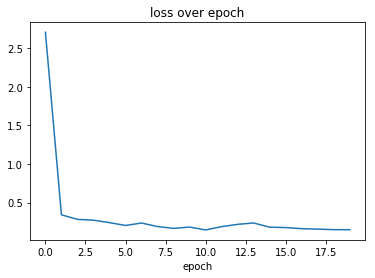

In [66]:
iterations = np.array([ i for i in range(20)])
loss = np.array([2.705567, 0.340898, 0.282018, 0.271042, 0.239304,0.203041, 0.234283, 0.188844, 0.165259, 0.182072, 0.145260, 0.187554, 0.217451, 0.235032, 0.1805889, 0.175692, 0.161463, 0.155373, 0.148961, 0.147712])

plt.figure()
plt.plot(loss)
plt.title('loss over epoch')
plt.xlabel('epoch')
plt.show()

# Varying the hidden layer size

In the example above we picked a hidden layer size of 3. Let's now get a sense of how varying the hidden layer size affects the result.


In [68]:
hidden_layer_dimensions = [50, 100]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    model = build_model(nn_hdim)
    print("final loss of a model with %d hidden layer size : %f" % (nn_hdim, calculate_loss(model)))

final loss of a model with 50 hidden layer size : 0.025917
final loss of a model with 100 hidden layer size : 0.037119


We can see that while a hidden layer of low dimensionality nicely capture the general trend of our data, but higher dimensionalities are prone to overfitting. They are "memorizing" the data as opposed to fitting the general shape. If we were to evaluate our model on a separate test set (and you should!) the model with a smaller hidden layer size would likely perform better because it generalizes better. We could counteract overfitting with stronger regularization, but picking the a correct size for hidden layer is a much more "economical" solution.

---
## Problem 2

Implement neural network with a 2-hidden layer to improve your model's validation / test accuracy as much as you can. You just can copy and paste the code above, but since relevant materials can appear on the exam, I strongly recommend you to implement it yourself.

Here are some things you can try:

1. Instead of batch gradient descent, use minibatch gradient descent ([more info](http://cs231n.github.io/optimization-1/#gd)) to train the network. Minibatch gradient descent typically performs better in practice. 
2. We used a fixed learning rate $\epsilon$ for gradient descent. Implement an annealing schedule for the gradient descent learning rate ([more info](http://cs231n.github.io/neural-networks-3/#anneal)). 
3. We used a $\tanh$ activation function for our hidden layer. Experiment with other activation functions (some are mentioned above). Note that changing the activation function also means changing the backpropagation derivative.

**Evaluation**: Use print_loss option and show the model actually train. 

---

In [187]:
print(__doc__)

# hyperparameters setting (2 hidden layers deep neural network)
hd1 = 10 #hidden layer 1 dimension
hd2 = 10
epsilon = 0.01
reg_lambda = 0.01
iteration = 1000
nn_input_dim = 784 # input layer dimensionality
nn_output_dim = 10 # output layer dimensionality

#layer = {'X' : h1, 'W' : W1, 'b' : b1, 'g' : ReLU}

#activation function
def ReLU(input) :
    return np.maximum(input, 0)

def tanh(input) :
    return np.tanh(input)

def softmax(input) :
    a = np.exp(input)
    probs = a / np.sum(a, axis = 1, keepdims = True)
    return probs

#derivative of ReLU
def d_ReLU(input) :
    return (input>0) * 1

def d_tanh(input) :
    return 1-tanh(input)**2

#feedforward propagation : a(l) -> z(l) -> a(l+1)
def one_layer_forward_prop(layer) :
    x = layer['X']
    W = layer['W']
    b = layer['b']
    g = layer['g']
    
    z = x.dot(W) + b
    a = g(z)
    return z, a

#backprop and update
def one_layer_back_prop(layer, dz, batch_size) :
    x = layer['X']
    W = layer['W']
    b = layer['b']
    g = layer['g']
    
    db = np.sum(dz, axis = 0, keepdims = True) / batch_size
    dW = np.dot(x.T, dz) / batch_size
    
    # Add regularization terms (b don't have regularization terms)
    dW += reg_lambda * W

    # Gradient descent parameter update
    W += -epsilon * dW
    b += -epsilon * db
                
    dx = np.dot(dz, W.T)
    return dx
    
def calculate_loss(model, probs, labels):
    # Calculating the loss
    data_loss = np.sum(labels * np.log(probs))
    # corect_logprobs = -np.log([probs[i,np.nonzero(train_labels)[(1)][i].astype('int64')] for i in range(mb)])
    #data_loss = np.sum(loss)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(model['W1'])) + np.sum(np.square(model['W2']))+ np.sum(np.square(model['W3'])))
    return 1./num_examples * data_loss

 TODO 


In [144]:
## 연습장
#label = train_labels[0:2,0:3]
label = np.array([[1, 0, 0], [0,0,1]])
probs = np.array([[0.2, 0.4, 0.4],[0.3,0.4,0.3]])

print(label*probs)
print(np.sum(label * probs).astype('float32'))

print(softmax(label))

[[0.2 0.  0. ]
 [0.  0.  0.3]]
0.5
[[0.57611688 0.21194156 0.21194156]
 [0.21194156 0.21194156 0.57611688]]


In [185]:
def randomize(dataset, labels, batch_size):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_labels = labels[permutation]
    shuffled_labels = shuffled_labels[:batch_size]
    shuffled_dataset = dataset[permutation]
    shuffled_dataset = shuffled_dataset[:batch_size]
    return shuffled_dataset, shuffled_labels

def accuracy(model, y_data, y_label) :
    W1 = model['W1']
    W2 = model['W2']
    W3 = model['W3']
    b1 = model['b1']
    b2 = model['b2']
    b3 = model['b3']
    
    layer1 = {'X' : y_data, 'W' : W1, 'b' : b1, 'g' : ReLU}
    z1, a1 = one_layer_forward_prop(layer1)
    layer2 = {'X' : a1, 'W' : W2, 'b' : b2, 'g' : ReLU}
    z2, a2 = one_layer_forward_prop(layer2)
    layer3 = {'X' : a2, 'W' : W3, 'b' : b3, 'g' : softmax}       
    z3, out = one_layer_forward_prop(layer3)    
    
    model = np.argmax(out, axis = 1)
    label = np.argmax(y_label, axis = 1)
    #print(model, label)
    eq = np.equal(model, label)
    return np.mean(eq)

def dnn_model(hd1, hd2, iteration, minibatch_size, print_loss=False):
    
    nn_hdim1 = hd1
    nn_hdim2 = hd2
    mb = minibatch_size
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    #weight initialization for each activation function
    W1 = np.random.randn(nn_input_dim, nn_hdim1) / np.sqrt(nn_input_dim/2)
    b1 = np.zeros((1, nn_hdim1))
    W2 = np.random.randn(nn_hdim1, nn_hdim2) / np.sqrt(nn_hdim1/2)
    b2 = np.zeros((1, nn_hdim2))    
    W3 = np.random.randn(nn_hdim2, nn_output_dim) / np.sqrt(nn_hdim2/2)
    b3 = np.zeros((1, nn_output_dim))
    
    model = {}
    train_acc = []
    test_acc = []
    #question : minibatch를 할 때 매 iteration마다 무작위로 선정?
    for i in range(iteration) :
        r_train_dataset, r_train_labels = randomize(train_dataset, train_labels, mb)
        r_test_dataset, r_test_labels = randomize(test_dataset, test_labels, 1000)
        
        #input layer -> hidden layer 1 -> hidden_layer2 -> output layer
        layer1 = {'X' : r_train_dataset, 'W' : W1, 'b' : b1, 'g' : ReLU}
        z1, a1 = one_layer_forward_prop(layer1)
        layer2 = {'X' : a1, 'W' : W2, 'b' : b2, 'g' : ReLU}
        z2, a2 = one_layer_forward_prop(layer2)
        layer3 = {'X' : a2, 'W' : W3, 'b' : b3, 'g' : softmax}       
        z3, out = one_layer_forward_prop(layer3)
        
        #back-prop & update
        dz3 = out - r_train_labels
        da2 = one_layer_back_prop(layer3, dz3, mb)
        dz2 = da2 * d_ReLU(z2)
        #dz2 = da2 * d_tanh(z2)
        da1 = one_layer_back_prop(layer2, dz2, mb)
        dz1 = da1 * d_ReLU(z1)
        #dz1 = da2 * d_tanh(z1)
        dx = one_layer_back_prop(layer1, dz1, mb)
        
        model = {'W1': W1, 'W2': W2, 'W3': W3, 'b1': b1, 'b2': b2, 'b3': b3 }
        
        if print_loss and i % 500 ==0:
            #print(out[0])
            print("Loss after iteration %d: %.4f" % (i, calculate_loss(model, out, r_train_labels)))
            tr_acc = accuracy(model, r_train_dataset, r_train_labels)
            te_acc = accuracy(model, r_test_dataset, r_test_labels)
            train_acc.append(tr_acc)
            test_acc.append(te_acc)
            print("Train Accuracy after iteration %d: %.4f" % (i, tr_acc))
            print("Test Accuracy after iteration %d: %.4f\n" % (i, te_acc))
    
    plt.figure()
    x = [(i+1) for i in range(10)]
    plt.plot(x,train_acc, label = 'train accuracy')
    plt.plot(x,test_acc, label = 'test accuracy')
    
    plt.xlabel('iteration')
    plt.ylabel('Accuarcy')
    plt.legend()
    plt.show()
    
    return model

## DNN with 2 hidden layers(ReLU)

Loss after iteration 0: -0.1161
Train Accuracy after iteration 0: 0.0800
Test Accuracy after iteration 0: 0.0900

Loss after iteration 500: -0.0770
Train Accuracy after iteration 500: 0.5600
Test Accuracy after iteration 500: 0.6100

Loss after iteration 1000: -0.0578
Train Accuracy after iteration 1000: 0.6200
Test Accuracy after iteration 1000: 0.7100

Loss after iteration 1500: -0.0334
Train Accuracy after iteration 1500: 0.8200
Test Accuracy after iteration 1500: 0.7800

Loss after iteration 2000: -0.0347
Train Accuracy after iteration 2000: 0.8200
Test Accuracy after iteration 2000: 0.8500

Loss after iteration 2500: -0.0332
Train Accuracy after iteration 2500: 0.8400
Test Accuracy after iteration 2500: 0.8600

Loss after iteration 3000: -0.0274
Train Accuracy after iteration 3000: 0.8500
Test Accuracy after iteration 3000: 0.8300

Loss after iteration 3500: -0.0370
Train Accuracy after iteration 3500: 0.8000
Test Accuracy after iteration 3500: 0.8400

Loss after iteration 4000: -

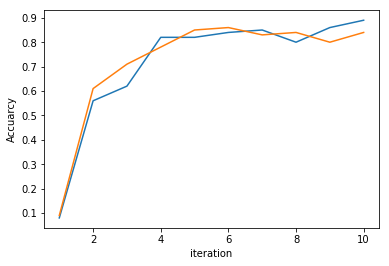

In [178]:
# weight initializatoin with / fan_in
#train_dataset 2000 / test_dataset 100
model = dnn_model(hd1, hd2, iteration = 5000, minibatch_size = 100, print_loss = True)

Loss after iteration 0: -0.1198
Train Accuracy after iteration 0: 0.0800
Test Accuracy after iteration 0: 0.0900

Loss after iteration 500: -0.0616
Train Accuracy after iteration 500: 0.6400
Test Accuracy after iteration 500: 0.6700

Loss after iteration 1000: -0.0497
Train Accuracy after iteration 1000: 0.6600
Test Accuracy after iteration 1000: 0.7800

Loss after iteration 1500: -0.0302
Train Accuracy after iteration 1500: 0.8400
Test Accuracy after iteration 1500: 0.8000

Loss after iteration 2000: -0.0344
Train Accuracy after iteration 2000: 0.8300
Test Accuracy after iteration 2000: 0.8400

Loss after iteration 2500: -0.0300
Train Accuracy after iteration 2500: 0.8300
Test Accuracy after iteration 2500: 0.8700

Loss after iteration 3000: -0.0267
Train Accuracy after iteration 3000: 0.8300
Test Accuracy after iteration 3000: 0.8400

Loss after iteration 3500: -0.0343
Train Accuracy after iteration 3500: 0.8100
Test Accuracy after iteration 3500: 0.8400

Loss after iteration 4000: -

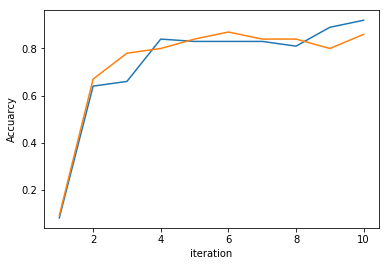

In [180]:
# weight initializatoin with He initialization (/ fan_in/2)
#train_dataset 2000 / test_dataset 100
#epoch 5000*100/2000 = 250
model = dnn_model(hd1, hd2, iteration = 5000, minibatch_size = 100, print_loss = True)

Loss after iteration 0: -0.1198
Train Accuracy after iteration 0: 0.0800
Test Accuracy after iteration 0: 0.0880

Loss after iteration 500: -0.0616
Train Accuracy after iteration 500: 0.6400
Test Accuracy after iteration 500: 0.6610

Loss after iteration 1000: -0.0497
Train Accuracy after iteration 1000: 0.6600
Test Accuracy after iteration 1000: 0.7730

Loss after iteration 1500: -0.0302
Train Accuracy after iteration 1500: 0.8400
Test Accuracy after iteration 1500: 0.8420

Loss after iteration 2000: -0.0344
Train Accuracy after iteration 2000: 0.8300
Test Accuracy after iteration 2000: 0.8520

Loss after iteration 2500: -0.0300
Train Accuracy after iteration 2500: 0.8300
Test Accuracy after iteration 2500: 0.8370

Loss after iteration 3000: -0.0267
Train Accuracy after iteration 3000: 0.8300
Test Accuracy after iteration 3000: 0.8640

Loss after iteration 3500: -0.0343
Train Accuracy after iteration 3500: 0.8100
Test Accuracy after iteration 3500: 0.8570

Loss after iteration 4000: -

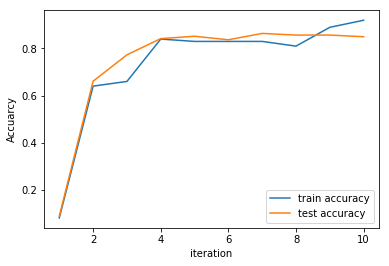

Loss after iteration 0: -0.0115
Train Accuracy after iteration 0: 0.1000
Test Accuracy after iteration 0: 0.0830

Loss after iteration 500: -0.0089
Train Accuracy after iteration 500: 0.5000
Test Accuracy after iteration 500: 0.5500

Loss after iteration 1000: -0.0068
Train Accuracy after iteration 1000: 0.6000
Test Accuracy after iteration 1000: 0.7850

Loss after iteration 1500: -0.0043
Train Accuracy after iteration 1500: 0.6000
Test Accuracy after iteration 1500: 0.7920

Loss after iteration 2000: -0.0028
Train Accuracy after iteration 2000: 0.9000
Test Accuracy after iteration 2000: 0.8280

Loss after iteration 2500: -0.0047
Train Accuracy after iteration 2500: 0.9000
Test Accuracy after iteration 2500: 0.8200

Loss after iteration 3000: -0.0053
Train Accuracy after iteration 3000: 0.6000
Test Accuracy after iteration 3000: 0.8570

Loss after iteration 3500: -0.0033
Train Accuracy after iteration 3500: 0.7000
Test Accuracy after iteration 3500: 0.8380

Loss after iteration 4000: -

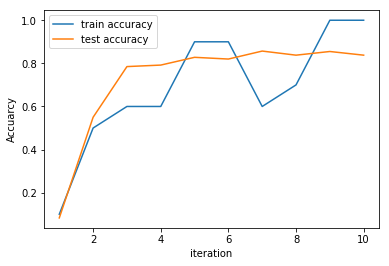

In [186]:
#He initialization & minibatch size 10
#train_dataset 2000 / test_dataset 1000
#epoch 5000*10/2000 = 25
model = dnn_model(hd1, hd2, iteration = 5000, minibatch_size = 100, print_loss = True)
model = dnn_model(hd1, hd2, iteration = 5000, minibatch_size = 10, print_loss = True)

## DNN with 2 hidden layers( )